In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from collections import defaultdict

# Check if MPS is available and set the device
device = (
    torch.device("mps") 
    if torch.backends.mps.is_available() 
    else torch.device("cpu")
)
print(f"Using device: {device}")

torch.manual_seed(1338)

Using device: mps


In [15]:
# Generate data, x, for each dim bernoulli distribution for activiation and then uniform for value
def generate_data(sample_dim=8192, n_samples=1000, sparse_probs=0.5):
    berns = np.random.binomial(1, sparse_probs, (n_samples, sample_dim))
    uniforms = np.random.uniform(0, 1, (n_samples, sample_dim))
    # Convert numpy arrays to torch tensors and move to device
    return torch.from_numpy((berns * uniforms).astype(np.float32)).to(device)

#should print ~1/4 of sample_dim
print(generate_data()[0].sum())

tensor(2060.4141, device='mps:0')


In [16]:
class AutoEncoder(nn.Module):
    def __init__(self, sample_dim, width_ratio, activation=nn.ReLU()):
        super().__init__()
        self.hidden_dim = int(sample_dim * width_ratio)
        self.Win = nn.Parameter(
            nn.init.kaiming_uniform_(
                torch.empty(sample_dim, self.hidden_dim, device=device), 
                nonlinearity="relu"
            )
        )
        self.Wout = nn.Parameter(
            nn.init.kaiming_uniform_(
                torch.empty(self.hidden_dim, sample_dim, device=device), 
                nonlinearity="relu"
            )
        )
        self.b = nn.Parameter(torch.zeros(sample_dim, device=device))
        self.activation = activation

    def forward(self, x):
        linear_out = x @ self.Win @ self.Wout + self.b
        return self.activation(linear_out)

In [25]:
class BatchedAutoEncoder(nn.Module):
    def __init__(self, n_models, sample_dim, width_ratio, activation=nn.ReLU()):
        super().__init__()
        self.n_models = n_models
        self.hidden_dim = int(sample_dim * width_ratio)
        self.Win = nn.Parameter(
            nn.init.kaiming_uniform_(
                torch.empty(n_models, sample_dim, self.hidden_dim, device=device),
                nonlinearity="relu"
            )
        )
        self.Wout = nn.Parameter(
            nn.init.kaiming_uniform_(
                torch.empty(n_models, self.hidden_dim, sample_dim, device=device),
                nonlinearity="relu"
            )
        )
        self.b = nn.Parameter(torch.zeros(n_models, sample_dim, device=device))
        self.activation = activation

    def forward(self, x):
        linear_out = x @ self.Win @ self.Wout 
        #torch does not support broadcasting for 3d tensors so we have to add the bias manually
        linear_out += self.b.unsqueeze(1)
        return self.activation(linear_out)

In [18]:
def train(model, train_data, test_data, batch_size=128, n_epochs=1000):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    mse_criterion = nn.MSELoss()
    
    # Ensure batch_size isn't larger than dataset
    batch_size = min(batch_size, len(train_data), len(test_data))
    
    n_batches = max(len(train_data) // batch_size, 1)
    n_test_batches = max(len(test_data) // batch_size, 1)
    
    for epoch in tqdm(range(n_epochs)):
        train_loss = 0
        test_loss = 0
        
        batch_perm = torch.randperm(len(train_data), device=device)
        batch_test_perm = torch.randperm(len(test_data), device=device)
        
        # Training
        for i in range(n_batches):
            batch = batch_perm[i * batch_size : min((i + 1) * batch_size, len(train_data))]
            x = train_data[batch]
            optimizer.zero_grad()
            loss = mse_criterion(model(x), x)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        # Testing
        with torch.no_grad():
            for i in range(n_test_batches):
                batch = batch_test_perm[i * batch_size : min((i + 1) * batch_size, len(test_data))]
                x = test_data[batch]
                test_loss += mse_criterion(model(x), x).item()
        
        if epoch % 100 == 0:
            avg_train_loss = train_loss / n_batches
            avg_test_loss = test_loss / n_test_batches
            #print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

    #model self.Win
    Win = model.Win.detach().cpu().numpy()
    Wout = model.Wout.detach().cpu().numpy()
    W = Win @ Wout

    return avg_train_loss, W

In [19]:
def batch_train(model, train_data, test_data, batch_size=128, n_epochs=1000):
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    mse_criterion = nn.MSELoss(reduction='none')  # Use 'none' to compute loss per element

    # Ensure batch_size isn't larger than dataset
    batch_size = min(batch_size, train_data.size(1), test_data.size(1))

    n_batches = max(train_data.size(1) // batch_size, 1)
    n_test_batches = max(test_data.size(1) // batch_size, 1)

    for epoch in tqdm(range(n_epochs)):
        train_loss = 0
        test_loss = 0

        # Shuffle the samples (not the models)
        batch_perm = torch.randperm(train_data.size(1), device=device)
        batch_test_perm = torch.randperm(test_data.size(1), device=device)

        # Training
        for i in range(n_batches):
            # Get batch indices
            batch_indices = batch_perm[i * batch_size : min((i + 1) * batch_size, train_data.size(1))]
            x = train_data[:, batch_indices, :]  # Shape: (n_models, batch_size, sample_dim)

            # Forward pass
            optimizer.zero_grad()
            predictions = model(x)  # Shape: (n_models, batch_size, sample_dim)
            loss = mse_criterion(predictions, x)  # Shape: (n_models, batch_size, sample_dim)

            # Average loss over all models, samples, and dimensions
            loss = loss.mean()  # Scalar
            train_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Testing
        with torch.no_grad():
            for i in range(n_test_batches):
                # Get batch indices
                batch_indices = batch_test_perm[i * batch_size : min((i + 1) * batch_size, test_data.size(1))]
                x = test_data[:, batch_indices, :]  # Shape: (n_models, batch_size, sample_dim)

                # Forward pass
                predictions = model(x)  # Shape: (n_models, batch_size, sample_dim)
                loss = mse_criterion(predictions, x)  # Shape: (n_models, batch_size, sample_dim)

                # Average loss over all models, samples, and dimensions
                test_loss += loss.mean().item()

        # Print progress
        if epoch % 100 == 0:
            avg_train_loss = train_loss / n_batches
            avg_test_loss = test_loss / n_test_batches
            print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")

    # Return final average losses and the learned weights
    avg_train_loss = train_loss / n_batches
    avg_test_loss = test_loss / n_test_batches
    W = model.Win.detach().cpu().numpy() @ model.Wout.detach().cpu().numpy()

    return avg_train_loss, W

In [20]:
def run_experiment(sample_dim, width_ratio, sparse_probs, n_samples, batch_size, n_epochs):
    # Data is already generated as a tensor on the correct device
    data = generate_data(sample_dim, n_samples, sparse_probs)
    
    # Split data 80/20
    train_size = int(n_samples * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]
    
    # Create model and move to device
    model = AutoEncoder(sample_dim, width_ratio).to(device)
    
    # Train model (no need for additional tensor conversion since data is already in correct format)
    avg_train_loss, W = train(model, train_data, test_data, batch_size=batch_size, n_epochs=n_epochs)
    
    return avg_train_loss, W

In [21]:
def run_batch_experiment(sample_dim, width_ratio, sparse_probs, n_samples, batch_size, n_epochs):
    # Data is already generated as a tensor on the correct device
    data = torch.stack([generate_data(sample_dim, n_samples, sparse_prob) for sparse_prob in sparse_probs])
    
    # Split data 80/20
    train_size = int(n_samples * 0.8)
    train_data = data[:, :train_size, :]
    test_data = data[:, train_size:, :]
    
    # Create model and move to device
    model = BatchedAutoEncoder(len(sparse_probs), sample_dim, width_ratio).to(device)
    
    # Train model (no need for additional tensor conversion since data is already in correct format)
    avg_train_loss, W = batch_train(model, train_data, test_data, batch_size=batch_size, n_epochs=n_epochs)
    
    return avg_train_loss, W

In [27]:
sparse_probs = [0.1, 0.3, 0.5, 0.7, 0.9]

loss, W = run_batch_experiment(512, 0.1, sparse_probs, 1000, 128, 1000)

  1%|          | 6/1000 [00:00<00:42, 23.44it/s]

Epoch 0, Train Loss: 0.140908, Test Loss: 0.095685


 11%|█         | 108/1000 [00:03<00:25, 35.60it/s]

Epoch 100, Train Loss: 0.064016, Test Loss: 0.080186


 20%|██        | 205/1000 [00:05<00:21, 36.78it/s]

Epoch 200, Train Loss: 0.058284, Test Loss: 0.079632


 30%|███       | 305/1000 [00:08<00:19, 36.50it/s]

Epoch 300, Train Loss: 0.056810, Test Loss: 0.080859


 41%|████      | 406/1000 [00:11<00:16, 36.51it/s]

Epoch 400, Train Loss: 0.056349, Test Loss: 0.082702


 51%|█████     | 508/1000 [00:14<00:12, 37.96it/s]

Epoch 500, Train Loss: 0.055937, Test Loss: 0.084722


 60%|██████    | 605/1000 [00:16<00:10, 36.15it/s]

Epoch 600, Train Loss: 0.055807, Test Loss: 0.086278


 70%|███████   | 705/1000 [00:19<00:07, 37.47it/s]

Epoch 700, Train Loss: 0.055657, Test Loss: 0.088148


 80%|████████  | 805/1000 [00:22<00:05, 34.54it/s]

Epoch 800, Train Loss: 0.055560, Test Loss: 0.090256


 90%|█████████ | 905/1000 [00:25<00:02, 35.68it/s]

Epoch 900, Train Loss: 0.055498, Test Loss: 0.093246


100%|██████████| 1000/1000 [00:27<00:00, 36.04it/s]


In [162]:
ratios = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9]
sparse_probs = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9]

losses = {}

for ratio in ratios:
    losses[ratio] = run_experiment(
        sample_dim=512, 
        width_ratio=ratio, 
        sparse_probs=0.04, 
        n_samples=1000, 
        batch_size=128, 
        n_epochs=2000
    )

100%|██████████| 2000/2000 [00:43<00:00, 45.79it/s]


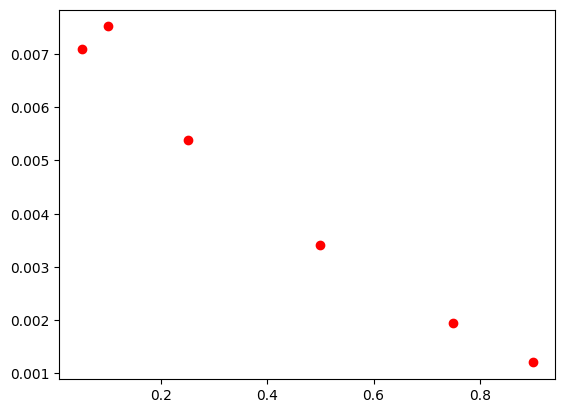

In [163]:
#plot losses
fig, ax = plt.subplots()
for ratio, (train_loss, test_loss) in losses.items():
    ax.plot(ratio, train_loss, "ro")

In [166]:
ratios = [0.05, 0.1, 0.25, 0.5, 0.75, 0.9]
sparse_probs = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9]

losses_and_weights = {}

for sparse_prob in sparse_probs:
    losses_and_weights[sparse_prob] = {}
    for ratio in ratios:
        _, W = run_experiment(
            sample_dim=128, 
            width_ratio=ratio, 
            sparse_probs=sparse_prob, 
            n_samples=1000, 
            batch_size=128, 
            n_epochs=1000
        )
        losses_and_weights[sparse_prob][ratio] = W

100%|██████████| 1000/1000 [00:17<00:00, 57.84it/s]


In [195]:
#for each weight, calculate the square of the sum of each row off diagonal, then variance across rows
def off_diag_sum_squared_var(W):
    W = W - np.diag(np.diag(W))
    W = W**2
    sum = W.sum(axis=1)
    return sum.var()


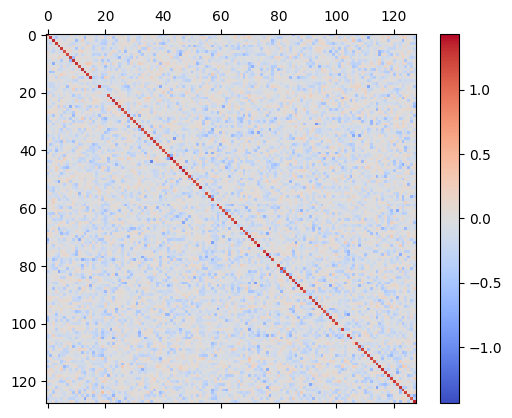

In [208]:
#heatmap of weights
weights = losses_and_weights[0.05][0.5]
fig, ax = plt.subplots()
vmax=weights.max()
vmin=-1*weights.max()
cax = ax.matshow(weights, cmap="coolwarm",vmin=vmin, vmax=vmax)
#color bar please
fig.colorbar(cax)

Text(0.5, 0, 'Sparse Probability')

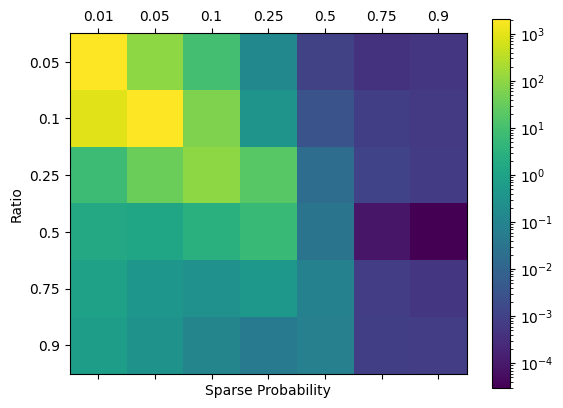

In [210]:
from matplotlib.colors import LogNorm

variance_matrix = np.zeros((len(sparse_probs), len(ratios)))

for i, sparse_prob in enumerate(sparse_probs):
    for j, ratio in enumerate(ratios):
        W = losses_and_weights[sparse_prob][ratio]
        variance_matrix[i,j] = off_diag_sum_squared_var(W)

fig, ax = plt.subplots()
cax = ax.matshow(variance_matrix.T, cmap="viridis", norm=LogNorm())
plt.colorbar(cax)

ax.set_yticks(np.arange(len(ratios)))
ax.set_xticks(np.arange(len(sparse_probs)))
ax.set_yticklabels(ratios)
ax.set_xticklabels(sparse_probs)
plt.ylabel('Ratio')
plt.xlabel('Sparse Probability')